In [1]:
#pip install pyramid.arima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import timedelta
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from statsmodels.tsa.holtwinters import Holt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

### Helper functions

In [2]:
# Own Function
def cluster_select(df, col, cluster, attribute):
    df = df[df[col] == cluster]
    df = pd.DataFrame(df.groupby('days')[attribute].mean())
    return(df)


def movie_select(movie_name, df, attribute):
    movie_name = movie_name
    movies = df[df['replace'] == movie_name]
    movies.index = movies['days']
    movie = movies[[attribute]]
    return(movie)

In [3]:
def movie_calc_auto(df, days, exponential, smoothing_level, smoothing_slope):
    days = days
    test = df[365 - days:]
    train = df[:365 - days]
    train = train.dropna()
    
    # Naive
    dd = np.asarray(train)
    dd = np.repeat(dd[-1], len(test))
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd)-1]

    # Holt
    fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
    y_hat['holt'] = fit1.forecast(len(test))

    # Arima
    model = auto_arima(np.asarray(train), error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(test))
    y_hat['arima'] = forecast
    print(model)
    
    
    # Plot
    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(y_hat['arima'], label = 'Arima')
    plt.plot(y_hat['holt'], label = 'Holt')
    plt.plot(y_hat['naive'], label = 'Naive')
    plt.legend()
    plt.show

    rms_holt = sqrt(mse(test, y_hat['holt']))
    rms_arima = sqrt(mse(test, y_hat['arima']))
    rms_naive = sqrt(mse(test, y_hat['naive']))
    x = pd.DataFrame(np.array([rms_holt, rms_arima, rms_naive]), index = ['Holt', 'Arima', 'Naive'], columns = ['RMSE'])
    x = x.sort_values(by=['RMSE'])
    
    return(x)


def movie_calc_manual(df, days, exponential, smoothing_level, smoothing_slope, p, d, q):
    days = days
    test = df[365 - days:]
    train = df[:365 - days]
    train = train.dropna()
    
    # Naive
    dd = np.asarray(train)
    dd = np.repeat(dd[-1], len(test))
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd)-1]

    # Holt
    fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
    y_hat['holt'] = fit1.forecast(len(test))

    # Arima
    model = auto_arima(np.asarray(train), order = (p,d,q), error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(test))
    y_hat['arima'] = forecast
    
    
    # Plot
    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(y_hat['arima'], label = 'Arima')
    plt.plot(y_hat['holt'], label = 'Holt')
    plt.plot(y_hat['naive'], label = 'Naive')
    plt.legend()
    plt.show

    rms_holt = sqrt(mse(test, y_hat['holt']))
    rms_arima = sqrt(mse(test, y_hat['arima']))
    rms_naive = sqrt(mse(test, y_hat['naive']))
    x = pd.DataFrame(np.array([rms_holt, rms_arima, rms_naive]), index = ['Holt', 'Arima', 'Naive'], columns = ['RMSE'])
    x = x.sort_values(by=['RMSE'])
    
    return(x)

In [4]:
def movie_calc_manual_loop(df, days, exponential, smoothing_level, smoothing_slope, p, d, q):
    days = days
    test = df[365 - days:]
    train = df[:365 - days]
    train = train.dropna()
    
    # Naive
    dd = np.asarray(train)
    dd = np.repeat(dd[-1], len(test))
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd)-1]

    # Holt
    fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
    y_hat['holt'] = fit1.forecast(len(test))

    # Arima
    model = auto_arima(np.asarray(train), order = (p,d,q), error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(test))
    y_hat['arima'] = forecast
    

    rms_holt = sqrt(mse(test, y_hat['holt']))
    rms_arima = sqrt(mse(test, y_hat['arima']))
    rms_naive = sqrt(mse(test, y_hat['naive']))
    x = pd.DataFrame(np.array([rms_holt, rms_arima, rms_naive]), index = ['Holt', 'Arima', 'Naive'], columns = ['RMSE'])
    
    return(x)

### 1. Load Data & Preprocessing

In [5]:
cluster = pd.read_csv('cluster_interaction.csv')
brand = pd.read_csv('../data_concat/movies.csv') 
brand = pd.merge(brand, cluster, left_on='replace', right_on='replace', how = 'right')

In [6]:
fb_1k = pd.read_table('../data/view_brand_rollup_facebook_1k-10k.tsv')
fb_10k = pd.read_table('../data/view_brand_rollup_facebook_10kplus.tsv')
fb = pd.concat([fb_1k, fb_10k])
fb = pd.merge(fb, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

insta_1k = pd.read_table('../data/view_brand_rollup_instagram_1k-10k.tsv')
insta_10k = pd.read_table('../data/view_brand_rollup_instagram_10kplus.tsv')
insta = pd.concat([insta_1k, insta_10k])
insta = pd.merge(insta, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

twit_1k = pd.read_table('../data/view_brand_rollup_twitter_1k-10k.tsv')
twit_10k = pd.read_table('../data/view_brand_rollup_twitter_10kplus.tsv')
twit = pd.concat([twit_1k, twit_10k])
twit = pd.merge(twit, brand, left_on = 'movie_id', right_on = 'brand_ods_id', how = 'left')

In [7]:
fb['data_for']= pd.to_datetime(fb['data_for']) 
fb['released_on'] = pd.to_datetime(fb['released_on'])
fb['days_after_release'] = fb['data_for'] - fb['released_on'] 
fb = fb[(fb['days_after_release'] <= '0 days') & (fb['days_after_release'] >= '-365 days')]
fb['days'] = fb['days_after_release'] + timedelta(days=365)

insta['data_for']= pd.to_datetime(insta['data_for']) 
insta['released_on'] = pd.to_datetime(insta['released_on'])
insta['days_after_release'] = insta['data_for'] - insta['released_on'] 
insta = insta[(insta['days_after_release'] <= '0 days') & (insta['days_after_release'] >= '-365 days')]
insta['days'] = insta['days_after_release'] + timedelta(days=365)

twit['data_for']= pd.to_datetime(twit['data_for']) 
twit['released_on'] = pd.to_datetime(twit['released_on'])
twit['days_after_release'] = twit['data_for'] - twit['released_on'] 
twit = twit[(twit['days_after_release'] <= '0 days') & (twit['days_after_release'] >= '-365 days')]
twit['days'] = twit['days_after_release'] + timedelta(days=365)

### 2. Selecting Movie / Cluster and Data Column for Prediction

### Cluster 0

In [8]:
fb_movie = cluster_select(fb, 'cluster_id_5', 0, 'total_post_interactions')

<function matplotlib.pyplot.show(*args, **kw)>

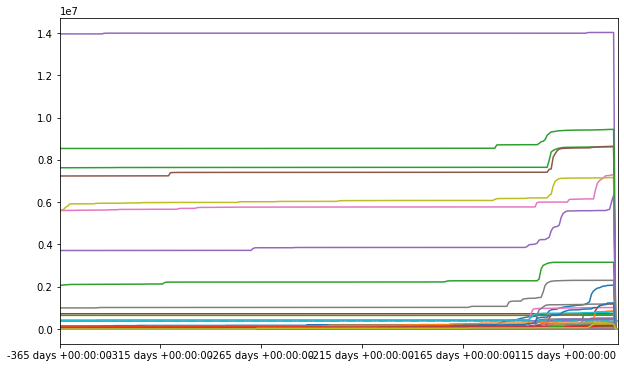

In [34]:
df = pd.read_csv('cluster_interaction.csv', index_col = 'replace')
cluster0 = df[df['cluster_id_5'] == 0]
cluster0.T.plot(figsize=(10,6), legend=False)
plt.plot(fb_movie, ls = '-.')
plt.show

In [32]:
fb_movie = cluster_select(fb, 'cluster_id_5', 0, 'total_post_interactions')

### 3. Split train/test

<function matplotlib.pyplot.show(*args, **kw)>

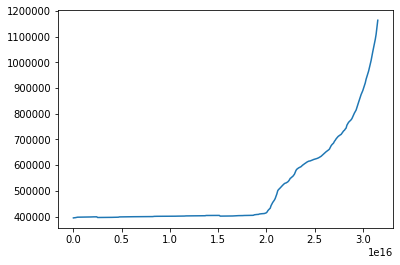

In [10]:
plt.plot(fb_movie)
plt.show

Looking at the plot, 150 days out might give wildly inaccurate forecasts because of the exponential trend appearing much later. At day 250 (~100 days out would be a benchmark) as it would give producers insights on how the trend would look like 3 months out. If it is not desirable, producers can therefore try to change metrics. 

We will try:

__90 days (3 months)__

__60 days (2 months)__ 

__30 days (1 month)__

In [11]:
days = 90
test = fb_movie[365 - days:]
train = fb_movie[:365 - days]

<function matplotlib.pyplot.show(*args, **kw)>

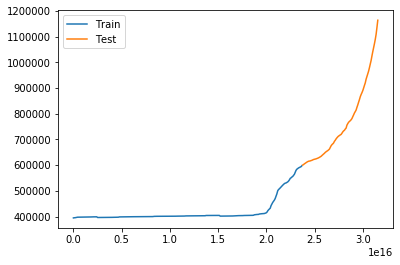

In [12]:
plt.figure()
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.legend(loc='best')
plt.show

### 4. Train Models

We will use different models:

a. Naive (basic model to compare against)

b. Holt's Linear (we will not use holt winters because data does not have seasonal trend)

d. ARIMA 

### 90 Days

#### a. Naive 

In [13]:
dd = np.asarray(train)
dd = np.repeat(dd[-1], len(test))
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

RMSE is:  221202.11


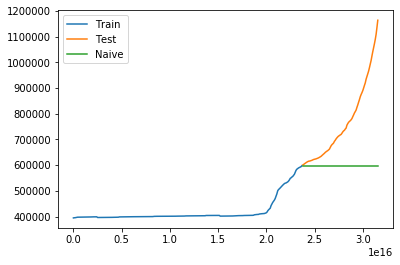

In [14]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat['naive'], label = 'Naive')
plt.legend()
plt.show

rms_naive = sqrt(mse(test, y_hat.naive))
print('RMSE is: ', round(rms_naive,2))

#### b. Holt's Linear
As we see an increasing exponential trend, we will use set exponential parameter as True and tune smoothing_level and smoothing_slope. (To be done later)

In [15]:
exponential = False
smoothing_level = np.arange(0, 1, 0.1)
smoothing_slope = np.arange(0, 1, 0.1)

In [16]:
dat = []
for level in smoothing_level:
    for slope in smoothing_slope:
        y_hat_holt= test.copy()
        fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = level, smoothing_slope = slope)
        y_hat_holt['holt'] = fit1.forecast(len(test))
        rms_holt = sqrt(mse(test, y_hat_holt['holt']))
        x = [level, slope, rms_holt]
        dat.append(x)
        
dat = pd.DataFrame(dat, columns = ['level', 'slope', 'rmse'])
dat.sort_values(['rmse']).head(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,level,slope,rmse
23,0.2,0.3,64878.554803
22,0.2,0.2,65633.554999
21,0.2,0.1,66645.218845
31,0.3,0.1,66982.093256
11,0.1,0.1,67115.844473


In [17]:
smoothing_level = 0.2
smoothing_slope = 0.3

y_hat_holt= test.copy()

fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = smoothing_level, smoothing_slope = smoothing_slope)
y_hat_holt['holt'] = fit1.forecast(len(test))

RMSE is:  64878.55


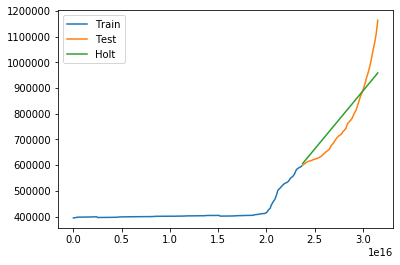

In [18]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat_holt['holt'], label = 'Holt')
plt.legend()
plt.show

rms_holt = sqrt(mse(test, y_hat_holt['holt']))
print('RMSE is: ', round(rms_holt,2))

#### 3. Arima (auto-arima)

In [19]:
model = auto_arima(np.asarray(train), trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

y_hat_arima = test.copy()
forecast = model.predict(n_periods=len(test))
y_hat_arima['arima'] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=4541.815, BIC=4563.472, Time=0.340 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=4532.278, BIC=4539.497, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=4534.598, BIC=4545.427, Time=0.043 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=4534.634, BIC=4545.462, Time=0.042 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=4530.316, BIC=4533.925, Time=0.008 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=4536.719, BIC=4551.157, Time=0.044 seconds
Total fit time: 0.501 seconds


RMSE is:  69827.64


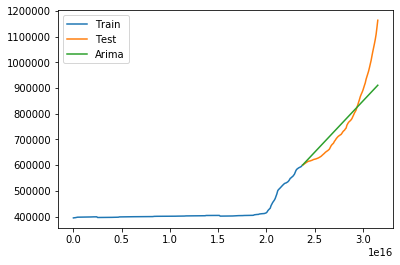

In [20]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_hat_arima['arima'], label = 'Arima')
plt.legend()
plt.show

rms_arima = sqrt(mse(test, y_hat_arima['arima']))
print('RMSE is: ', round(rms_arima,2))

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Holt,64878.554803
Arima,69827.642201
Naive,221202.112378


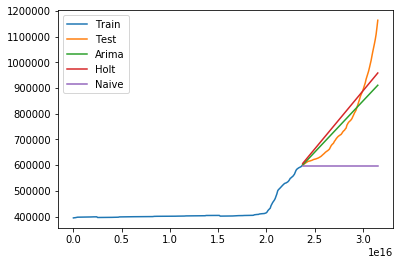

In [21]:
movie_calc_auto(fb_movie, 90, False, 0.2, 0.3)

### 60 days

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Holt,120427.694426
Arima,140113.896723
Naive,222131.654745


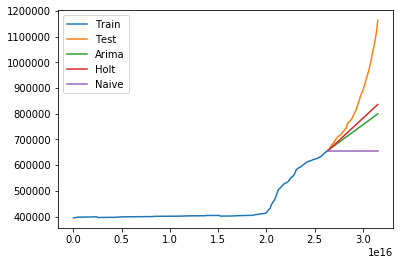

In [22]:
movie_calc_auto(fb_movie, 60, False, 0.2, 0.3)

### 30 Days

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Holt,96280.410358
Arima,105482.564472
Naive,189878.382512


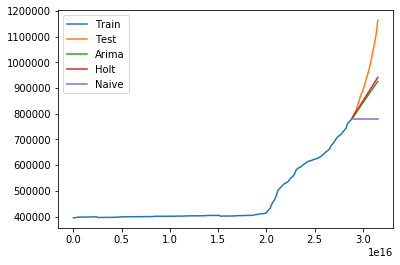

In [23]:
movie_calc_auto(fb_movie, 30, False, 0.2, 0.3)

#### Best Parameters:

ARIMA: (0,2,0)

Holt: smoothing level = 0.2, smoothing slope = 0.3

In [25]:
movie_clusters = fb[fb['cluster_id_5'] == 0]['replace'].unique()

__Movie 1__

In [26]:
rand_movie = movie_clusters[0]
rand_movie

'McFarland, USA'

,RMSE
Arima,49221.062533
Naive,49765.647680
Holt,52043.759632


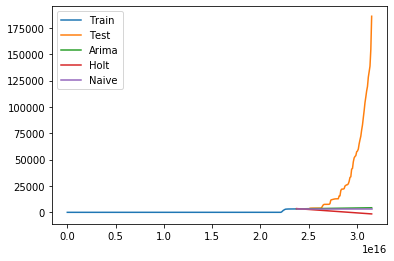

In [27]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, False, 0.2, 0.3, 0, 2, 0)

,RMSE
Arima,58821.294785
Naive,60262.951316
Holt,60476.291806


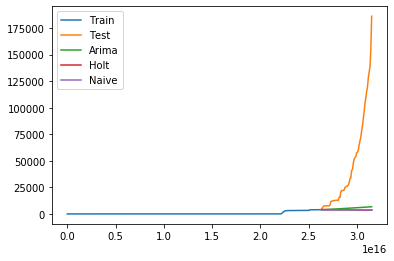

In [28]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 60, False, 0.2, 0.3, 0, 2, 0)

,RMSE
Holt,42796.314807
Arima,47546.138436
Naive,65944.793131


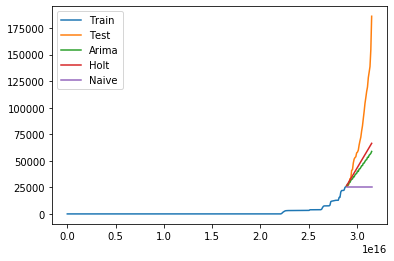

In [29]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 30, False, 0.2, 0.3, 0, 2, 0)

__Movie 2__

In [30]:
rand_movie = movie_clusters[1]
rand_movie

'Fury'

,RMSE
Arima,238794.522824
Holt,307775.598921
Naive,421457.632246


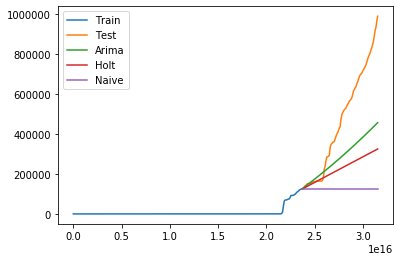

In [31]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, False, 0.2, 0.3, 0, 2, 0)

,RMSE
Arima,113537.274624
Holt,117252.553204
Naive,369700.237383


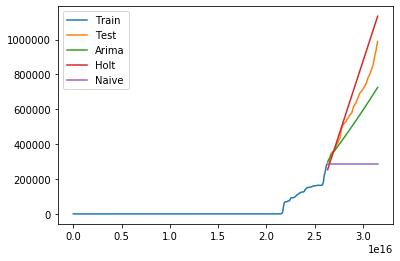

In [32]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 60, False, 0.2, 0.3, 0, 2, 0)

,RMSE
Arima,40473.073451
Holt,75761.523861
Naive,206929.063699


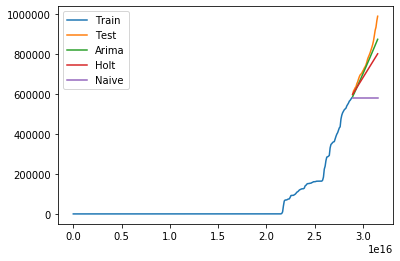

In [33]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 30, False, 0.2, 0.3, 0, 2, 0)

__Movie 3__

In [34]:
rand_movie = movie_clusters[2]
rand_movie

'Get On Up'

,RMSE
Arima,266111.573548
Holt,304078.914137
Naive,312662.503333


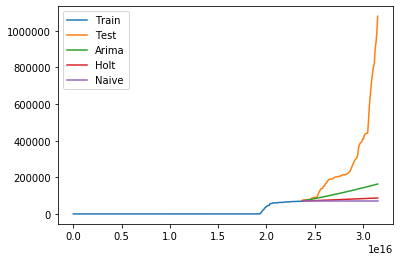

In [35]:
select = movie_select(rand_movie, fb, 'total_post_interactions')
movie_calc_manual(select, 90, False, 0.2, 0.3, 0, 2, 0)

,RMSE
Holt,141522.096664
Arima,144946.089323
Naive,306445.752917


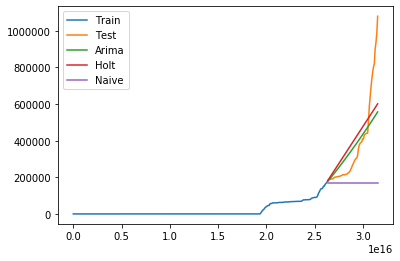

In [36]:
movie_calc_manual(select, 60, False, 0.2, 0.3, 0, 2, 0)

,RMSE
Arima,196890.725274
Holt,289527.385851
Naive,360120.458675


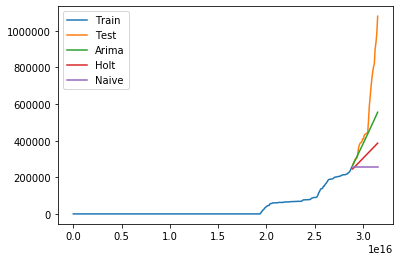

In [37]:
movie_calc_manual(select, 30, False, 0.2, 0.3, 0, 2, 0)

### Looping through movies

In [47]:
c1_days_90 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 90, False, 0.2, 0.3, 0, 2, 0).T
        c1_days_90 = c1_days_90.append(x, ignore_index=True)
        
    except:
        pass

In [61]:
pd.DataFrame(np.array(c1_days_90).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Naive,229528.388070
Holt,284113.650818
Arima,285437.094959


In [49]:
c1_days_60 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 60, False, 0.2, 0.3, 0, 2, 0).T
        c1_days_60 = c1_days_60.append(x, ignore_index=True)
        
    except:
        pass

In [62]:
pd.DataFrame(np.array(c1_days_60).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Holt,184852.313700
Arima,194791.181232
Naive,228809.532383


In [51]:
c1_days_30 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 30, False, 0.2, 0.3, 0, 2, 0).T
        c1_days_30 = c1_days_30.append(x, ignore_index=True)
        
    except:
        pass

In [63]:
pd.DataFrame(np.array(c1_days_30).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Arima,142128.082611
Holt,153550.838605
Naive,193726.061433


### Cluster 2

In [25]:
fb_movie = cluster_select(fb, 'cluster_id_5', 1, 'total_post_interactions')
days = 90
test = fb_movie[365 - days:]
train = fb_movie[:365 - days]

exponential = False
smoothing_level = np.arange(0, 1, 0.1)
smoothing_slope = np.arange(0, 1, 0.1)

dat = []
for level in smoothing_level:
    for slope in smoothing_slope:
        y_hat_holt= test.copy()
        fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = level, smoothing_slope = slope)
        y_hat_holt['holt'] = fit1.forecast(len(test))
        rms_holt = sqrt(mse(test, y_hat_holt['holt']))
        x = [level, slope, rms_holt]
        dat.append(x)
        
dat = pd.DataFrame(dat, columns = ['level', 'slope', 'rmse'])
dat.sort_values(['rmse']).head(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

,level,slope,rmse
49,0.4,0.9,146098.557013
59,0.5,0.9,150020.888495
58,0.5,0.8,154745.749083
48,0.4,0.8,158926.433713
57,0.5,0.7,163423.125078


In [21]:
fb_movie = cluster_select(fb, 'cluster_id_5', 1, 'total_post_interactions')
days = 60
test = fb_movie[365 - days:]
train = fb_movie[:365 - days]

exponential = False
smoothing_level = np.arange(0, 1, 0.1)
smoothing_slope = np.arange(0, 1, 0.1)

dat = []
for level in smoothing_level:
    for slope in smoothing_slope:
        y_hat_holt= test.copy()
        fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = level, smoothing_slope = slope)
        y_hat_holt['holt'] = fit1.forecast(len(test))
        rms_holt = sqrt(mse(test, y_hat_holt['holt']))
        x = [level, slope, rms_holt]
        dat.append(x)
        
dat = pd.DataFrame(dat, columns = ['level', 'slope', 'rmse'])
dat.sort_values(['rmse']).head(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

,level,slope,rmse
29,0.2,0.9,94022.110299
39,0.3,0.9,97508.102471
38,0.3,0.8,100612.972017
28,0.2,0.8,102484.411835
37,0.3,0.7,106152.649926


In [22]:
fb_movie = cluster_select(fb, 'cluster_id_5', 1, 'total_post_interactions')
days = 30
test = fb_movie[365 - days:]
train = fb_movie[:365 - days]

exponential = False
smoothing_level = np.arange(0, 1, 0.1)
smoothing_slope = np.arange(0, 1, 0.1)

dat = []
for level in smoothing_level:
    for slope in smoothing_slope:
        y_hat_holt= test.copy()
        fit1 = Holt(np.asarray(train), exponential = exponential).fit(smoothing_level = level, smoothing_slope = slope)
        y_hat_holt['holt'] = fit1.forecast(len(test))
        rms_holt = sqrt(mse(test, y_hat_holt['holt']))
        x = [level, slope, rms_holt]
        dat.append(x)
        
dat = pd.DataFrame(dat, columns = ['level', 'slope', 'rmse'])
dat.sort_values(['rmse']).head(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

,level,slope,rmse
99,0.9,0.9,37254.021142
89,0.8,0.9,38763.506024
98,0.9,0.8,41677.483715
79,0.7,0.9,43026.607439
88,0.8,0.8,44457.852172


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Holt,146098.557013
Arima,247848.123654
Naive,502315.779780


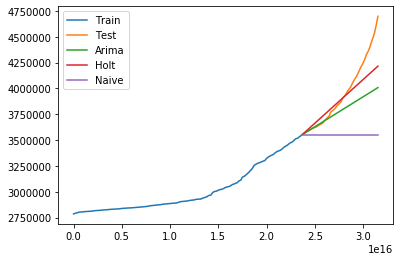

In [74]:
movie_calc_auto(fb_movie, 90, False, 0.4, 0.9)

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Holt,123840.014377
Arima,158990.113851
Naive,470034.204882


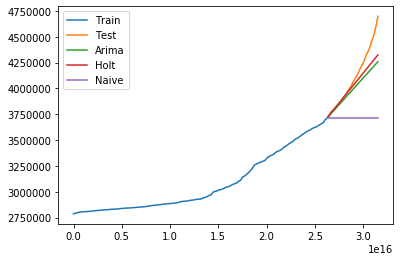

In [75]:
movie_calc_auto(fb_movie, 60, False, 0.4, 0.9)

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)


,RMSE
Arima,34896.565041
Holt,73006.165266
Naive,332173.580124


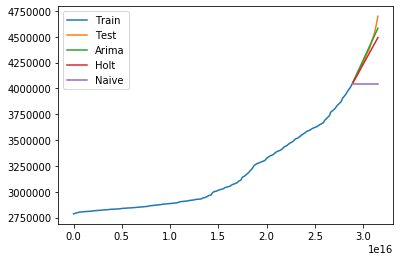

In [76]:
movie_calc_auto(fb_movie, 30, False, 0.4, 0.9)

#### Best Parameters:

ARIMA: (0,2,0)

Holt: 
1. 90 days: smoothing level = 0.4, smoothing slope = 0.9
2. 60 days: 0.2, 0.9
3. 30 days: 0.9, 0.9

In [24]:
movie_clusters = fb[fb['cluster_id_5'] == 1]['replace'].unique()

__90 days__

In [25]:
c2_days_90 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 90, False, 0.4, 0.9, 0, 2, 0).T
        c2_days_90 = c2_days_90.append(x, ignore_index=True)
        
    except:
        pass

In [26]:
pd.DataFrame(np.array(c2_days_90).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Arima,394224.718727
Naive,512661.044475
Holt,529170.981649


__60 days__

In [27]:
c2_days_60 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 60, False, 0.4, 0.9, 0, 2, 0).T
        c2_days_60 = c2_days_60.append(x, ignore_index=True)
        
    except:
        pass
    
pd.DataFrame(np.array(c2_days_60).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Arima,385828.700029
Naive,478920.971385
Holt,511528.450559


In [28]:
c2_days_60 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 60, False, 0.2, 0.9, 0, 2, 0).T
        c2_days_60 = c2_days_60.append(x, ignore_index=True)
        
    except:
        pass
    
pd.DataFrame(np.array(c2_days_60).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Arima,385828.700029
Naive,478920.971385
Holt,579421.154880


__30 days__

In [31]:
c2_days_30 = pd.DataFrame()

for movie in movie_clusters:
    select = movie_select(movie, fb, 'total_post_interactions')
    try:
        x = movie_calc_manual_loop(select, 30, False, 0.9, 0.9, 0, 2, 0).T
        c2_days_30 = c2_days_30.append(x, ignore_index=True)
        
    except:
        pass
    
pd.DataFrame(np.array(c2_days_30).mean(axis=0), index = ['Holt', 'Arima', 'Naive'],  columns = ['RMSE']).sort_values(['RMSE'])

,RMSE
Arima,222931.598752
Holt,236524.524899
Naive,335310.267219
